**# Projeto Final – Bootcamp CDIA (UniSENAI SC)**  
## Manutenção Preditiva (Multiclass)

**Objetivo:** desenvolver um sistema preditivo capaz de identificar o **tipo de falha principal** em máquinas industriais (multiclass)

**Entregas:** gerar `predicoes_multiclass.csv` com as **probabilidades por defeito** (`FDF`,`FDC`,`FP`,`FTE`,`FA`) para o conjunto de teste.

> Este notebook é o registro ddo desenvolvimento do projeto cuja ideia é mostrar o caminho, o   raciocínio e o passo a passoseguido para desenvolver o mesmo.


**O que foi usado**:
- ColumnTransformer para separar numéricas e categóricas
- Pipeline para organizar pré-processamento + modelo
- validação com StratifiedKFold
- importância de calibrar probabilidades quando a gente usa threshold

**Etapas seguidas no notebook, de acordo com as demandas do projeto**

1. Contexto e carregamento de dados  
2. Preparação dos rótulos (binários → multiclass com prioridade)  
3. EDA (seaborn+matplotlib): distribuição, correlação, classes  
4. Engenharia de atributos  
5. Split e validação (holdout + k-fold)  
6. Testes de modelos multiclass (Logistic Multinomial, RandomForest, GradientBoosting)  
7. Curvas ROC/PR (One-vs-Rest) por classe  
8. Threshold tuning (ganho de F1): regra de rejeição para `NONE`  
9. Calibração de probabilidades (CalibratedClassifierCV) para RF/GB  
10. Matriz de confusão normalizada e Top-Loss cases  
11. Explainability (Permutation Importance)  
12. Treino final e geração da submissão (`predicoes_multiclass.csv`)  
13. (Extra) Mini dashboard com Streamlit  



## 1) Setup do ambiente
Instalação das dependências e importação das bibliotecas.

In [1]:
%pip uninstall -y opencv-python opencv-contrib-python opencv-python-headless thinc umap-learn tsfresh

Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
Found existing installation: opencv-contrib-python 4.12.0.88
Uninstalling opencv-contrib-python-4.12.0.88:
  Successfully uninstalled opencv-contrib-python-4.12.0.88
Found existing installation: opencv-python-headless 4.12.0.88
Uninstalling opencv-python-headless-4.12.0.88:
  Successfully uninstalled opencv-python-headless-4.12.0.88
Found existing installation: thinc 8.3.6
Uninstalling thinc-8.3.6:
  Successfully uninstalled thinc-8.3.6
Found existing installation: umap-learn 0.5.9.post2
Uninstalling umap-learn-0.5.9.post2:
  Successfully uninstalled umap-learn-0.5.9.post2
Found existing installation: tsfresh 0.21.0
Uninstalling tsfresh-0.21.0:
  Successfully uninstalled tsfresh-0.21.0


In [1]:
!pip install -U "pip>=24.0" "setuptools>=70" "wheel>=0.43"
!pip install -U "numpy>=2,<2.3" "scipy>=1.14" "scikit-learn>=1.6" \
  opencv-python==4.12.0.88 opencv-contrib-python==4.12.0.88 opencv-python-headless==4.12.0.88 \
  thinc==8.3.6 umap-learn==0.5.9.post2

  Using cached numpy-2.2.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scikit_learn-1.7.1-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached thinc-8.3.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (15 kB)
  Using cached umap_learn-0.5.9.post2-py3-none-any.whl.metadata (25 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (67.0 MB)
Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (73.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install -U numpy pandas scipy scikit-learn seaborn matplotlib


### Seed e ajustes de visualização

Defino uma semente fixa para reprodutibilidade e aumento a largura do `display` do Pandas para enxergar mais colunas.


### Modelos que testei e por quê

- **LogisticRegression**: baseline linear e rápido para comparar  
- **RandomForest**: lida bem com não-linearidade e interações  
- **GradientBoosting**: bom para ajustes finos, às vezes melhor em F1 macro

### Validação estratificada (K-Fold com mesma proporção)

Uso StratifiedKFold para manter a proporção das classes em cada dobras, já que temos desbalanceamento.  
Métricas: **macro-F1** e **ROC-AUC OvR** para avaliar desempenho geral.

### Relatórios e matriz de confusão (onde estou errando)

Aqui interpreto onde o modelo erra mais.  
> Uma observação prévia é que: se uma classe for crítica no negócio, posso usar class_weight ou threshold tuning nessa classe.


### Curvas ROC/PR (o que eu olho)

- **ROC** é útil no geral, mas com classes desbalanceadas eu olho bastante **PR** (média de precisão para diferentes recalls).  
- Para decisão final, posso ajustar **threshold por classe** em vez de usar 0.5.

### Calibração de probabilidades (se eu usar threshold)

Se eu for usar as **probabilidades** para decidir com threshold, faz sentido calibrar (Platt/Isotonic) e checar a curva de calibração.  
Nem sempre melhora, mas ajuda quando as probabilidades estão “otimistas” demais.

In [1]:
#Importação das bibliotecas necessárias para análise de dados, visualização e modelagem preditiva

import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns

from google.colab import files

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, f1_score, roc_auc_score, log_loss,
                             precision_recall_curve, roc_curve, average_precision_score)

from sklearn.inspection import permutation_importance

#Definição da semente aleatória e configuração de exibição do Pandas

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
pd.set_option("display.max_columns", 200)


**O que eu entendi da matriz de confusão:**  
- Onde aparecem mais **falsos positivos** e **falsos negativos**?  
- Tem classe sendo **quase sempre confundida** com outra específica? (isso pode indicar falta de sinal/feature)  
- Se alguma classe tem poucos exemplos, a matriz pode ficar "vazia" pra ela — olho o **relatório por classe** também.

**Minha leitura das curvas:**  
- **ROC** bonita não garante bom desempenho em classe rara. Por isso olho **PR** com carinho.  
- Se a **precisão** cai muito quando aumento **recall**, talvez eu precise ajustar **threshold por classe** em vez de usar 0.5.  
- `average_precision` (AP) me dá um número-resumo da PR; bom pra comparar modelos.

**Sobre a calibração:**  
- Se eu for tomar decisão com base em **probabilidades**, é legal que elas estejam calibradas.  
- Às vezes o modelo é **otimista** (probabilidades altas demais). A curva de calibração mostra isso.  
- Nem sempre calibrar melhora F1, mas ajuda quando preciso de **thresholds** mais confiáveis.

**Minha leitura rápida:**  
- Onde o modelo está errando mais? Essas classes são importantes no negócio?  
- Preciso ajustar o `class_weight` ou o **threshold** de alguma classe específica?  
- Vale a pena tentar `GB` com outros hiperparâmetros ou simplificar o RF?


### Carregando os dados (jeito simples)

Aqui eu leio os CSVs. Observação: no Colab, se eu reabrir o notebook, pode ser preciso montar o Drive ou reenviar os arquivos.  
Usei este caminho porque foi o mais simples no meu ambiente.


In [3]:
import pandas as pd

# Lendo os CSVs que estão no diretório raiz do Colab
df_train = pd.read_csv("bootcamp_train.csv")
df_test  = pd.read_csv("bootcamp_test.csv")

# Conferindo dimensões
print("Treino:", df_train.shape)
print("Teste:", df_test.shape)

# Mostrando as 5 primeiras linhas
df_train.head()

Treino: (35260, 15)
Teste: (7173, 9)


,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,não,False,False,Não,False,Não
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,Não,False,False,Não,False,Não
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,NaN,Não,N,False,Não,False,Não
3,3,M20947,M,300.9,310.8,90.0,1599.0,33.0,7.0,não,False,False,Não,False,não
4,4,L53849,L,-36.0,310.5,90.0,1571.0,33.9,NaN,não,N,False,não,False,Não


### (Extra) Mini app com Streamlit (ter noção de previsões)

Incluí um rascunho de app para ter noção de previsões. É simples, mas me ajuda a “ver” o modelo fora do notebook.

In [4]:
df_train.head(3)

,id,id_produto,tipo,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta,falha_maquina,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
0,0,L56434,L,298.3,309.1,90.0,1616.0,31.1,195.0,não,False,False,Não,False,Não
1,1,L48741,L,298.2,308.4,90.0,1388.0,53.8,137.0,Não,False,False,Não,False,Não
2,2,L48850,L,298.2,307.8,90.0,1528.0,31.1,NaN,Não,N,False,Não,False,Não


## 3) Alvos – de 5 rótulos binários para **Multiclass (6 classes)**
**Motivação:** o desafio solicita testar **multiclass**. Criamos um alvo único por amostra com as classes:  
`NONE` (sem falha), `FDF`, `FDC`, `FP`, `FTE`, `FA`.  
Para raros casos de múltiplas falhas na mesma linha, aplicamos **prioridade** (segurança > térmico > potência > desgaste > aleatório):
`FTE > FDC > FP > FDF > FA`.

In [5]:
LABEL_RAW = [
    "FDF (Falha Desgaste Ferramenta)",
    "FDC (Falha Dissipacao Calor)",
    "FP (Falha Potencia)",
    "FTE (Falha Tensao Excessiva)",
    "FA (Falha Aleatoria)",
]

def to01(v):
    s = str(v).strip().lower()
    if s in {"true","sim","1","y","yes"}: return 1
    if s in {"false","nao","não","0","n","-"}: return 0
    return 0  # fallback conservador

Y_bin = df_train[LABEL_RAW].applymap(to01)
Y_bin.describe()

/tmp/ipython-input-3033553790.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Y_bin = df_train[LABEL_RAW].applymap(to01)


,FDF (Falha Desgaste Ferramenta),FDC (Falha Dissipacao Calor),FP (Falha Potencia),FTE (Falha Tensao Excessiva),FA (Falha Aleatoria)
count,35260.000000,35260.000000,35260.000000,35260.000000,35260.000000
mean,0.002014,0.006381,0.003573,0.004821,0.002099
std,0.044829,0.079628,0.059672,0.069269,0.045764
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


### Desbalanceamento (classe Maior  vs. classes pequenas)

As classes estão bem desbalanceadas (a `NONE` domina). Para não esconder as menores, uso **escala log no eixo Y** ou gráfico em %.

In [6]:
CLASSES = ["NONE","FDF","FDC","FP","FTE","FA"]
PRIORITY = ["FTE","FDC","FP","FDF","FA"]  # maior prioridade → menor

RAW2TAG = {
    "FDF (Falha Desgaste Ferramenta)":"FDF",
    "FDC (Falha Dissipacao Calor)":"FDC",
    "FP (Falha Potencia)":"FP",
    "FTE (Falha Tensao Excessiva)":"FTE",
    "FA (Falha Aleatoria)":"FA",
}

def to_multiclass(row):
    if row.sum()==0: return "NONE"
    for tag in PRIORITY:
        raw = [k for k,v in RAW2TAG.items() if v==tag][0]
        if row[raw]==1: return tag
    return "NONE"

y_mc = Y_bin.apply(to_multiclass, axis=1)
y_mc.value_counts()

,count
NONE,34612
FDC,219
FTE,170
FP,117
FA,73
FDF,69


**Minha leitura (rápida) do gráfico acima:**  
- Parece que tem **uma classe bem maior** (tipo a `NONE`) e várias **bem menores**.  
- Pra não perder as pequenas, costumo usar **escala log** no eixo Y ou plotar em **percentual**.  
- Observação: se a classe menor for crítica no negócio, vale pensar em `class_weight` ou reamostragem.

## 4) EDA – análise exploratória com seaborn + matplotlib
- **Sanidade**: tipos, nulos, estatísticas.  
- **Distribuição**: histogramas/boxplots das numéricas.  
- **Correlação**: heatmap.  
- **Classes**: distribuição de `y_mc` (multiclass).


In [7]:
ID_COLS  = ["id","id_produto","tipo"]
NUM_COLS = ["temperatura_ar","temperatura_processo","umidade_relativa",
            "velocidade_rotacional","torque","desgaste_da_ferramenta"]

df_train[ID_COLS + NUM_COLS].info()
print("\nNulos por coluna:")
print(df_train[ID_COLS + NUM_COLS].isna().sum().sort_values(ascending=False))
df_train[NUM_COLS].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35260 entries, 0 to 35259
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      35260 non-null  int64  
 1   id_produto              35260 non-null  object 
 2   tipo                    35260 non-null  object 
 3   temperatura_ar          34644 non-null  float64
 4   temperatura_processo    34661 non-null  float64
 5   umidade_relativa        35260 non-null  float64
 6   velocidade_rotacional   34509 non-null  float64
 7   torque                  34637 non-null  float64
 8   desgaste_da_ferramenta  34308 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 2.4+ MB

Nulos por coluna:
desgaste_da_ferramenta    952
velocidade_rotacional     751
torque                    623
temperatura_ar            616
temperatura_processo      599
id                          0
tipo                        0
id_produto        

,temperatura_ar,temperatura_processo,umidade_relativa,velocidade_rotacional,torque,desgaste_da_ferramenta
count,34644.000000,34661.000000,35260.000000,34509.000000,34637.000000,34308.000000
mean,269.535241,280.457676,89.997672,1380.194181,40.210357,74.373266
std,96.342224,96.943630,0.142191,494.098759,8.831626,110.411937
min,-36.000000,-38.000000,80.590429,-161.000000,3.800000,-202.000000
25%,297.900000,308.500000,90.000000,1408.000000,34.300000,28.000000
50%,299.600000,309.800000,90.000000,1483.000000,40.300000,94.000000
75%,301.100000,310.900000,90.000000,1574.000000,46.200000,155.000000
max,304.500000,313.800000,94.575256,2886.000000,76.600000,253.000000


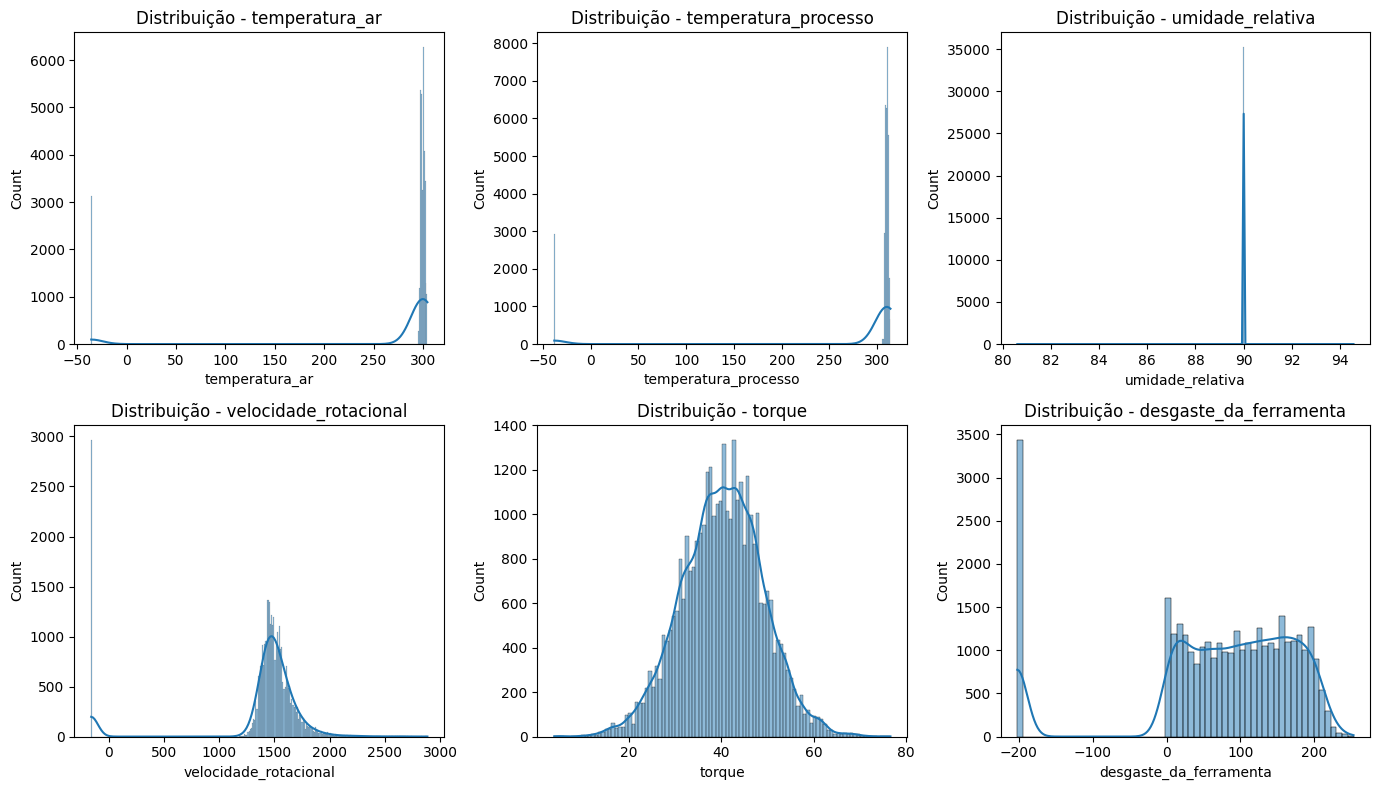

In [8]:
# Histograma para variáveis numéricas
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14,8))
axes = axes.ravel()
for i, c in enumerate(NUM_COLS):
    sns.histplot(df_train[c], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribuição - {c}")
plt.tight_layout(); plt.show()

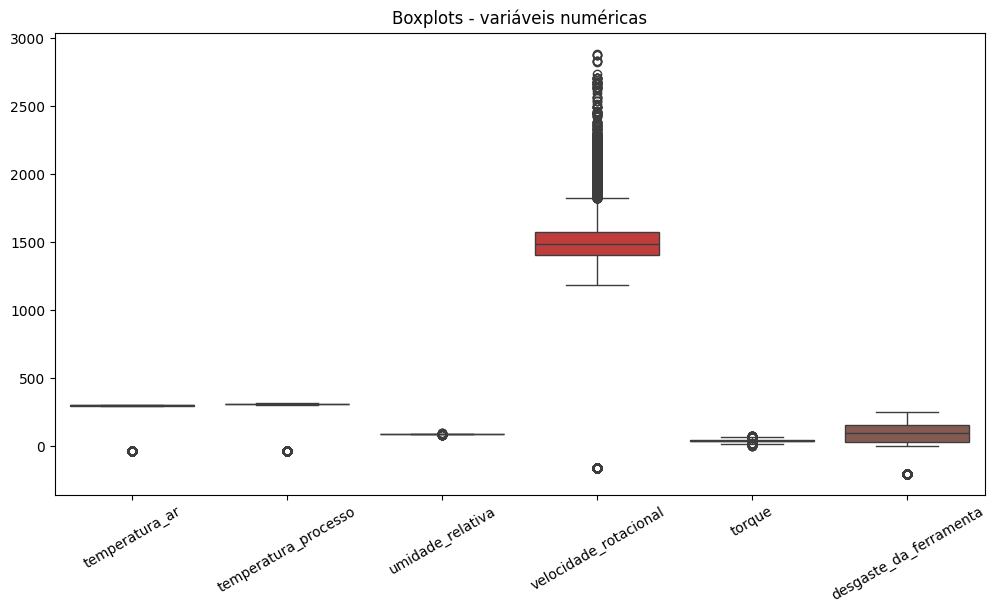

In [9]:
# Boxplots
plt.figure(figsize=(12,6))
sns.boxplot(data=df_train[NUM_COLS])
plt.title("Boxplots - variáveis numéricas")
plt.xticks(rotation=30)
plt.show()

Abaixo apresentamos a distribução na escala de log, para tornar mais visível.

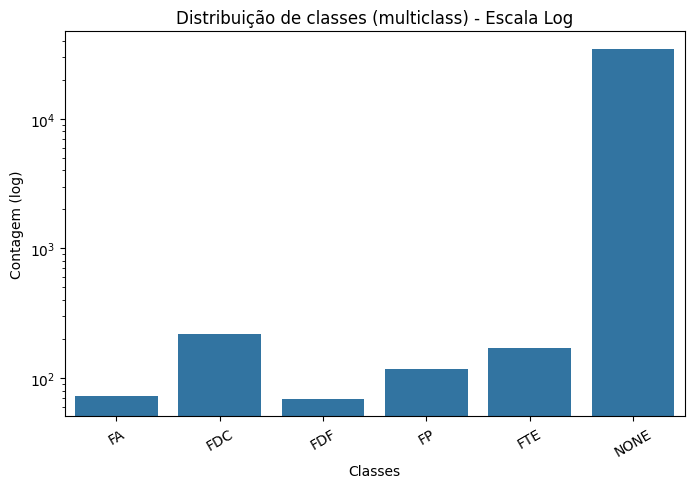

In [12]:
# Distribuição por calsses

plt.figure(figsize=(8,5))
sns.countplot(x=y_mc, order=sorted(y_mc.unique()))
plt.yscale("log")  # deixa o eixo Y em escala logarítmica
plt.title("Distribuição de classes (multiclass) - Escala Log")
plt.xlabel("Classes")
plt.ylabel("Contagem (log)")
plt.xticks(rotation=30)
plt.show()

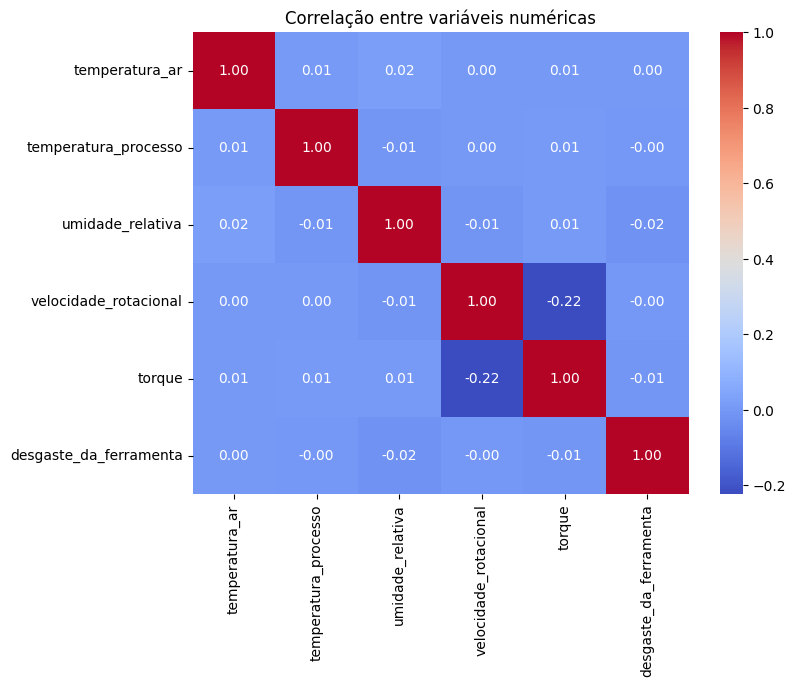

In [11]:
# Correlação
plt.figure(figsize=(8,6))
sns.heatmap(df_train[NUM_COLS].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação entre variáveis numéricas")
plt.show()

### 5) Engenharia de atributos
Aqui eu criei algumas variáveis novas a partir das originais, tentando dar um sentido físico pra elas:

- delta_temp: diferença entre a temperatura do processo e a do ar  
-`power_proxy: torque multiplicado pela rotação  
- torque_per_rpm: torque dividido pelo rpm  
- wear_per_power: desgaste dividido pela raiz quadrada do power_proxy  
- num_produto: peguei só os números do id_produto


In [13]:
def engineer_features(df):
    out = df.copy()
    out["num_produto"] = out["id_produto"].astype(str).str.extract(r"(\d+)").fillna("0").astype(int)
    out["delta_temp"] = out["temperatura_processo"] - out["temperatura_ar"]
    out["power_proxy"] = out["torque"] * out["velocidade_rotacional"]
    rpm = out["velocidade_rotacional"].replace(0, np.nan)
    out["torque_per_rpm"] = (out["torque"] / rpm).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    out["wear_per_power"] = out["desgaste_da_ferramenta"] / (np.sqrt(out["power_proxy"]) + 1e-6)
    return out

df_train_fe = engineer_features(df_train)
df_test_fe  = engineer_features(df_test)

CAT_COLS  = ["tipo"]
FEAT_COLS = ID_COLS + NUM_COLS + ["num_produto","delta_temp","power_proxy","torque_per_rpm","wear_per_power"]

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 6) Split (holdout) e pré-processamento
Holdout 80/20 *estratificado* por `y_mc` + `ColumnTransformer` com scaler (numéricos) e one-hot (categóricos).


In [14]:
X = df_train_fe[FEAT_COLS]
y = y_mc

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), [c for c in FEAT_COLS if c not in CAT_COLS]),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CAT_COLS),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

## 7) Testes de modelos (multiclass) com validação cruzada
Modelos testados:  
- **LogisticRegression** (multinomial, softmax) → boas probabilidades/calibração.  
- **RandomForest** → robusto, não-linear.  
- **GradientBoosting** → forte em tabular.

Métricas: **accuracy**, **macro-F1** (balanceia classes), **log-loss** (calibração).  

In [ ]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pandas as pd

# ============================
# 1. Definir scorers
# ============================
scorers = {
    "accuracy": "accuracy",
    "f1_macro": make_scorer(f1_score, average="macro"),
    "neg_log_loss": "neg_log_loss"
}

# ============================
# 2. Definir modelos
# ============================
models = {
    "logreg_multinomial": LogisticRegression(
        multi_class="multinomial", solver="lbfgs", max_iter=2000,
        class_weight="balanced", random_state=RANDOM_SEED
    ),
    "random_forest": RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_leaf=1,
        class_weight="balanced_subsample", random_state=RANDOM_SEED, n_jobs=-1
    ),
    "grad_boost": GradientBoostingClassifier(random_state=RANDOM_SEED)
}

# ============================
# 3. Pré-processamento com imputação
# ============================
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ]
)

# ============================
# 4. Função de avaliação
# ============================
def evaluate_cv(model, X, y, pre, scorers=scorers, n_splits=5, random_state=RANDOM_SEED):
    """Avalia modelo com cross-validation e retorna métricas (média e std)."""
    pipe = Pipeline([("pre", pre), ("clf", model)])
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = cross_validate(pipe, X, y, cv=cv, scoring=scorers, return_train_score=False)

    results = {}
    for k in scorers:
        results[f"cv_{k}_mean"] = float(scores[f"test_{k}"].mean())
        results[f"cv_{k}_std"] = float(scores[f"test_{k}"].std())
    return results

# ============================
# 5. Rodar avaliação
# ============================
results = {}
for name, mdl in models.items():
    print(f"🔎 Avaliando {name}...")
    results[name] = evaluate_cv(mdl, X, y, pre)

# ============================
# 6. Resultado final em DataFrame
# ============================
results_df = pd.DataFrame(results).T.sort_values(by="cv_f1_macro_mean", ascending=False)
display(results_df)


🔎 Avaliando logreg_multinomial...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

🔎 Avaliando random_forest...


## 8) Treino no holdout + Relatórios e Matriz de Confusão
Relatórios por classe (precision/recall/F1) e **matriz de confusão normalizada**.

In [ ]:
def fit_and_report(name, model, X_train, y_train, X_valid, y_valid, pre):
    pipe = Pipeline([("pre", pre), ("clf", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    y_proba = pipe.predict_proba(X_valid)

    acc  = accuracy_score(y_valid, y_pred)
    f1m  = f1_score(y_valid, y_pred, average="macro")
    ll   = log_loss(y_valid, y_proba, labels=sorted(np.unique(y_valid)))
    try:
        auc = roc_auc_score(pd.get_dummies(y_valid), y_proba, multi_class="ovr", average="macro")
    except Exception:
        auc = np.nan

    print(f"\n[{name}] ACC={acc:.4f}  F1_macro={f1m:.4f}  LogLoss={ll:.4f}  ROC-AUC_ovr_macro={auc:.4f}")
    print(classification_report(y_valid, y_pred, digits=4))

    plt.figure(figsize=(6,5))
    ConfusionMatrixDisplay.from_estimator(pipe, X_valid, y_valid,
                                          display_labels=sorted(np.unique(y_valid)),
                                          cmap="Blues", normalize="true")
    plt.title(f"Matriz de confusão normalizada – {name}")
    plt.show()

    return pipe, {"acc":acc, "f1_macro":f1m, "logloss":ll, "auc_macro":auc}

fitted = {}
summ = {}
for name, mdl in models.items():
    pipe, met = fit_and_report(name, mdl, X_train, y_train, X_valid, y_valid, pre)
    fitted[name] = pipe
    summ[name] = met

pd.DataFrame(summ).T



## 9) Curvas ROC e Precision-Recall por classe (OvR)
Avaliamos curvas **ROC** e **PR** para cada classe (tratando cada uma como positiva vs todas as demais).


In [ ]:
best_name = max(summ, key=lambda k: (summ[k]["f1_macro"], -summ[k]["logloss"]))
best_pipe = fitted[best_name]
print("Melhor modelo (holdout):", best_name)

y_proba = best_pipe.predict_proba(X_valid)
classes_order = best_pipe.named_steps["clf"].classes_
proba_df = pd.DataFrame(y_proba, columns=classes_order, index=y_valid.index)

for cls in classes_order:
    y_true_bin = (y_valid == cls).astype(int)
    y_score = proba_df[cls].values

    fpr, tpr, _ = roc_curve(y_true_bin, y_score)
    prec, rec, _ = precision_recall_curve(y_true_bin, y_score)
    ap = average_precision_score(y_true_bin, y_score)

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--',alpha=0.6)
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC – classe {cls}")
    plt.show()

    plt.figure(figsize=(5,4))
    plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR – classe {cls} (AP={ap:.3f})")
    plt.show()


## 10) Threshold tuning (ganho de F1) – Gate para `NONE`
**Ideia:** em vez de sempre usar `argmax`, aplicamos uma **regra de rejeição**:  
se `max(prob das classes de defeito) < T`, preveja **`NONE`**; caso contrário, **escolha a classe de defeito com maior probabilidade**.  
Buscamos o melhor **T** no holdout e comparamos o macro-F1.


In [ ]:
DEFECTS = ["FDF","FDC","FP","FTE","FA"]
def predict_with_gate(proba_df, T=0.5):
    out = []
    for i in range(len(proba_df)):
        row = proba_df.iloc[i]
        top_defect = row[DEFECTS].idxmax()
        top_prob   = row[DEFECTS].max()
        pred = top_defect if top_prob >= T else "NONE"
        out.append(pred)
    return np.array(out)

y_pred_argmax = proba_df.idxmax(axis=1).values
f1_argmax = f1_score(y_valid, y_pred_argmax, average="macro")

best_T, best_f1 = 0.0, -1
grid = np.linspace(0.2, 0.8, 13)
f1_hist = []
for T in grid:
    y_pred_gate = predict_with_gate(proba_df, T)
    f1m = f1_score(y_valid, y_pred_gate, average="macro")
    f1_hist.append((T, f1m))
    if f1m > best_f1:
        best_f1, best_T = f1m, T

print(f"F1_macro (argmax puro) = {f1_argmax:.4f}")
print(f"F1_macro (gate NONE)   = {best_f1:.4f}  @T={best_T:.2f}")

# Gráfico F1 vs Threshold
thr, f1s = zip(*f1_hist)
plt.figure(figsize=(6,4))
plt.plot(thr, f1s, marker='o')
plt.axhline(f1_argmax, ls='--', alpha=0.6, label='argmax')
plt.axvline(best_T, ls=':', alpha=0.6, label='T*')
plt.title("F1_macro vs Threshold (gate NONE)")
plt.xlabel("Threshold T"); plt.ylabel("F1_macro")
plt.legend(); plt.show()


## 11) Calibração de probabilidades (RF/GB)
Para modelos **RandomForest/GradientBoosting**, calibramos com `CalibratedClassifierCV` (sigmoid).  
Comparamos **log-loss** antes/depois e mostramos **calibration curve** para 1–2 classes.

In [ ]:
calib_candidates = [("random_forest","rf_calib"), ("grad_boost","gb_calib")]
calib_scores = {}

for base_name, tag in calib_candidates:
    if base_name in fitted:
        base = fitted[base_name]
        Xv = X_valid; yv = y_valid
        pre_only = base.named_steps["pre"]
        est_only = base.named_steps["clf"]
        Xtr_tr = pre_only.fit_transform(X_train, y_train)
        Xv_tr  = pre_only.transform(X_valid)

        calib = CalibratedClassifierCV(est_only, method="sigmoid", cv=3)
        calib.fit(Xtr_tr, y_train)
        y_proba_cal = calib.predict_proba(Xv_tr)
        ll = log_loss(yv, y_proba_cal, labels=sorted(np.unique(yv)))
        try:
            auc = roc_auc_score(pd.get_dummies(yv), y_proba_cal, multi_class="ovr", average="macro")
        except Exception:
            auc = np.nan
        calib_scores[tag] = {"logloss": float(ll), "auc_macro": float(auc)}

calib_scores

In [ ]:
# Curva de calibração para uma classe (ex.: FTE)
cls_show = "FTE"
for tag, scores in calib_scores.items():
    base_name = "random_forest" if "rf_" in tag else "grad_boost"
    base = fitted[base_name]
    pre_only = base.named_steps["pre"]
    est_only = base.named_steps["clf"]
    Xtr_tr = pre_only.fit_transform(X_train, y_train)
    Xv_tr  = pre_only.transform(X_valid)
    calib = CalibratedClassifierCV(est_only, method="sigmoid", cv=3).fit(Xtr_tr, y_train)
    classes_order = calib.classes_
    if cls_show in classes_order:
        idx = list(classes_order).index(cls_show)
        prob = calib.predict_proba(Xv_tr)[:, idx]
        y_true_bin = (y_valid == cls_show).astype(int)
        frac_pos, mean_pred = calibration_curve(y_true_bin, prob, n_bins=10)

        plt.figure(figsize=(5,4))
        plt.plot(mean_pred, frac_pos, marker="o")
        plt.plot([0,1],[0,1],'--',alpha=0.6)
        plt.xlabel("Prob prevista"); plt.ylabel("Fração positiva")
        plt.title(f"Calibration curve – {tag} – classe {cls_show}")
        plt.show()

## 12) Erros mais custosos no holdout)
Mostramos as **10 piores perdas individuais** (multiclass log-loss por amostra) para análise rápida.


In [ ]:
def per_sample_logloss(y_true, proba, classes):
    y_idx = y_true.map({c:i for i,c in enumerate(classes)}).values
    eps = 1e-15
    p_true = np.clip(proba[np.arange(len(y_true)), y_idx], eps, 1-eps)
    return -np.log(p_true)

y_proba_val = best_pipe.predict_proba(X_valid)
classes_order = best_pipe.named_steps["clf"].classes_.tolist()
losses = per_sample_logloss(y_valid, y_proba_val, classes_order)
worst_idx = np.argsort(-losses)[:10]

df_worst = X_valid.iloc[worst_idx].copy()
df_worst["true"] = y_valid.iloc[worst_idx].values
df_worst["pred"] = best_pipe.predict(X_valid.iloc[worst_idx])
df_worst["logloss"] = losses[worst_idx]
df_worst.sort_values("logloss", ascending=False)

## 13) Medimos importância de atributos via **Permutation Importance** sobre o holdout.


In [ ]:
r = permutation_importance(best_pipe, X_valid, y_valid, n_repeats=7, random_state=RANDOM_SEED, n_jobs=-1)
feat_names = best_pipe.named_steps["pre"].get_feature_names_out()
imp = pd.Series(r.importances_mean, index=feat_names).sort_values(ascending=True)

plt.figure(figsize=(8,6))
imp.tail(15).plot(kind="barh")
plt.title("Top 15 features por importância (Permutation Importance)")
plt.tight_layout(); plt.show()


## 14) Treino final e **submissão**
Treinamos o **melhor modelo** no **conjunto completo de treino** e geramos `predicoes_multiclass.csv` com as **probabilidades por defeito** (`FDF`,`FDC`,`FP`,`FTE`,`FA`) — ignorando a probabilidade de `NONE`.


In [ ]:
final_pipe = Pipeline([("pre", pre), ("clf", best_pipe.named_steps["clf"])])
final_pipe.fit(X, y)

proba_test = final_pipe.predict_proba(df_test_fe[FEAT_COLS])
classes_order = final_pipe.named_steps["clf"].classes_.tolist()

want = ["FDF","FDC","FP","FTE","FA"]
sub = pd.DataFrame({"id": df_test_fe["id"].values})
for w in want:
    idx = classes_order.index(w)
    sub[w] = proba_test[:, idx]

sub.head()


In [ ]:
UB_PATH = "predicoes_multiclass.csv"
sub.to_csv(SUB_PATH, index=False)
files.download(SUB_PATH)


## 15) (Extra) Mini dashboard com Streamlit
Demonstração rápida de EDA. **Opcional**, diferencial para a banca.

Para rodar fora do Colab (local):
```bash
pip install streamlit
streamlit run app.py
```

No Colab, pode exigir túnel (ngrok/localtunnel). Alternativa: baixe `app.py` e rode localmente.

In [ ]:
%%writefile app.py
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

st.set_page_config(page_title="Manutenção Preditiva", layout="wide")
st.title("Dashboard – Manutenção Preditiva (EDA)")

uploaded_train = st.file_uploader("Carregue o Bootcamp_train.csv", type=["csv"])
if uploaded_train is not None:
    df = pd.read_csv(uploaded_train)
    st.subheader("Amostra dos dados")
    st.dataframe(df.head(20))

    num_cols = df.select_dtypes(include=["float","int"]).columns.tolist()
    if num_cols:
        st.subheader("Distribuição de uma variável numérica")
        col = st.selectbox("Escolha a variável", num_cols)
        fig, ax = plt.subplots()
        sns.histplot(df[col], kde=True, ax=ax)
        st.pyplot(fig)

    st.subheader("Correlação (numéricas)")
    if num_cols:
        fig, ax = plt.subplots(figsize=(8,6))
        sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", ax=ax)
        st.pyplot(fig)
else:
    st.info("Aguardando upload do Bootcamp_train.csv")
